In [1]:
import random
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from tqdm.notebook import tqdm_notebook as tqdm
from torchtext import data
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from collections import Counter

# from torchtext.vocab import vocab

In [2]:
# load text corpus
wordsList = np.load('/Users/Rui/Desktop/MFFINTECH/NN/LSTM/training_data/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('/Users/Rui/Desktop/MFFINTECH/NN/LSTM/training_data/wordVectors.npy')
print ('Loaded the word vectors!')
# with open('glove.6B.50d.txt','rt') as f
# with open('wordVectors.npy','rt') as f:
print(len(wordsList))
print(wordVectors.shape)

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)


In [3]:
train_data, test_data = IMDB(split=('train', 'test'))
train_data = pd.DataFrame(train_data, columns=['sentiment', 'sentence'])
test_data = pd.DataFrame(test_data, columns=['sentiment', 'sentence'])
# train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)
# train_data = train_data.mask(train_data.astype(object).eq('None')).dropna() 
print(train_data.head(5))
print(set(train_data['sentiment']))
print(train_data.shape[0])

   sentiment                                           sentence
0          1  I rented I AM CURIOUS-YELLOW from my video sto...
1          1  "I Am Curious: Yellow" is a risible and preten...
2          1  If only to avoid making this type of film in t...
3          1  This film was probably inspired by Godard's Ma...
4          1  Oh, brother...after hearing about this ridicul...
{1, 2}
25000


In [4]:
# print(train_data['sentence'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = get_tokenizer('basic_english')

counter = Counter()
row = 0
for sentence in train_data['sentence']:
    try:
        counter.update(tokenizer(sentence))
        row += 1
    except:
        train_data = train_data.drop([row], axis=0)

# 构建id库  by n-bag-of-words
vocab = torchtext.vocab.vocab(counter, min_freq=1)  # min_freq only allows word with minimal frequency to build vocab, specials=('')
print(train_data.shape[0])

25000


In [5]:
# text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
# text_transform = lambda x: [vocab['']] + [vocab[token] for token in tokenizer(x)] + [vocab['']]

def text_transform(sentence, maxSeqLength = 250):
    sentence_vector = np.zeros(maxSeqLength)
    try:
        sentence_vector = [vocab[token] for token in tokenizer(sentence)]
        if len(sentence_vector) > maxSeqLength:
            sentence_vector = sentence_vector[:250]
        elif len(sentence_vector) < maxSeqLength:
            sentence_vector = sentence_vector.extend(np.zeros(maxSeqLength - len(sentence_vector)))
        return sentence_vector
    except: # exclude non english sentence
        return np.nan
    
train_data['sentence'] = list(map(lambda sentence: text_transform(sentence), train_data['sentence']))
# label_transform = lambda x: 2 if x == 'pos' else 1
print(train_data.head(5))
print(train_data.shape[0])
# train_data = train_data.mask(train_data.astype(object).eq('None')).dropna() 
train_data = train_data.dropna() 
print(train_data.head(5))
print(train_data.shape[0])

# valid_data['sentence'] = list(map(lambda sentence: text_transform(sentence), valid_data['sentence']))
test_data['sentence'] = list(map(lambda sentence: text_transform(sentence), test_data['sentence']))
test_data = test_data.dropna() 
print(test_data.shape[0])

   sentiment                                           sentence
0          1  [0, 1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...
1          1  [0, 2, 182, 183, 52, 41, 184, 89, 185, 186, 18...
2          1                                               None
3          1                                               None
4          1  [386, 38, 387, 22, 22, 22, 388, 389, 67, 36, 3...
25000
   sentiment                                           sentence
0          1  [0, 1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...
1          1  [0, 2, 182, 183, 52, 41, 184, 89, 185, 186, 18...
4          1  [386, 38, 387, 22, 22, 22, 388, 389, 67, 36, 3...
7          1  [16, 0, 18, 590, 41, 591, 9, 36, 382, 38, 0, 5...
8          1  [61, 117, 672, 673, 11, 452, 216, 11, 150, 216...
9391
906


In [6]:
def create_dataset(data):
    data_y = list(data['sentiment'])
    data_y = torch.tensor(data_y)
    data_x = list(map(lambda x: list(x), data['sentence'])) # 2d list of x
    data_x = torch.tensor(data_x)
#     data_x = pad_sequence(data_x, batch_first=True) # batch_first has shape [samples, features]
    print(data_x.shape)
    return TensorDataset(data_x, data_y)

train_dataset = create_dataset(train_data)
# valid_dataset = create_dataset(valid_data)
test_dataset = create_dataset(test_data)


torch.Size([9391, 250])
torch.Size([906, 250])


In [7]:
dl = DataLoader(train_dataset, batch_size=30, shuffle=True)
x, y = next(iter(dl))
embedding = nn.Embedding.from_pretrained(torch.from_numpy(wordVectors).float())
print(x.shape)
print(embedding(x).shape)
y = y.unsqueeze(1)
print(y.shape)
# print()

torch.Size([30, 250])
torch.Size([30, 250, 50])
torch.Size([30, 1])


In [8]:
class RNN(nn.Module):
#     self train embedding
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
#         self.rnn = nn.RNN(embedding_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#   pretrained embedding
    def __init__(self, wordVectors, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(wordVectors).float())
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(250*hidden_dim, output_dim)    
        self.hidden_dim = hidden_dim
        
    def forward(self, text):
        #text = [sent len, batch size] 
        #text = [batch size, sent len] 
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        #embedded = [batch size, sent len, emb dim]
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #output = [batch size, sent len, hid dim]
        #hidden = [1, batch size, hid dim]
        #hidden = [batch size, 1, hid dim]
        output = output.view(output.size(0), 250 * self.hidden_dim)  # -1 means sequence length * hidden_dim
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
#         return self.fc(hidden.squeeze(0))
        return self.fc(output)


In [9]:
# INPUT_DIM = sentence_size+1
# INPUT_DIM = 537
# print(INPUT_DIM)
EMBEDDING_DIM = wordVectors.shape[1]
HIDDEN_DIM = 252
OUTPUT_DIM = 1

model = RNN(wordVectors, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(device)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 139,609 trainable parameters


In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def train_model(model, train_dataset, test_dataset, loss_fn, output_dim, lr=0.001,
                batch_size=30, n_epochs=2,
                enable_checkpoint_ensemble=True):
    
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_test_preds = []
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        TP = 0
        
        for data in tqdm(train_loader, disable=False):

            x_batch = data[0]
            y_batch = data[1].unsqueeze(1) # from (30) to (30, 1)
            x_batch.to(device)
            y_batch.to(device)
            
            y_pred = model(x_batch) 
            loss = loss_fn(y_pred.float(), y_batch.float()) # float prevent tensor type difference

            optimizer.zero_grad() #梯度清零
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item() / len(train_loader)
            
            TP += torch.sum(y_pred == y_batch) 
            accuracy = TP / len(train_loader)
            
            
        loss_list.append(avg_loss)
        accuracy_list.append(accuracy)
        
        
        model.eval()
#         test_preds = np.zeros((len(test), output_dim))
    
#         for i, x_batch in enumerate(test_loader):
#             y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())

#             test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

#         all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t Acc: {:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, accuracy, elapsed_time))
        
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(loss_list, range(1, n_epochs+1))
    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Number of epochs")
    plt.show()
    
    ax.plot(accuracy_list, range(1, n_epochs+1))
    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs Number of epochs")
    plt.show()
    
#     if enable_checkpoint_ensemble:
#         test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
#     else:
#         test_preds = all_test_preds[-1]
        
#     return test_preds

  0%|          | 0/314 [00:00<?, ?it/s]

Epoch 1/2 	 loss=-20045.0104 	 Acc: 0.0000 	 time=22.76s


  0%|          | 0/314 [00:00<?, ?it/s]

Epoch 2/2 	 loss=-24928.9776 	 Acc: 0.0000 	 time=22.48s


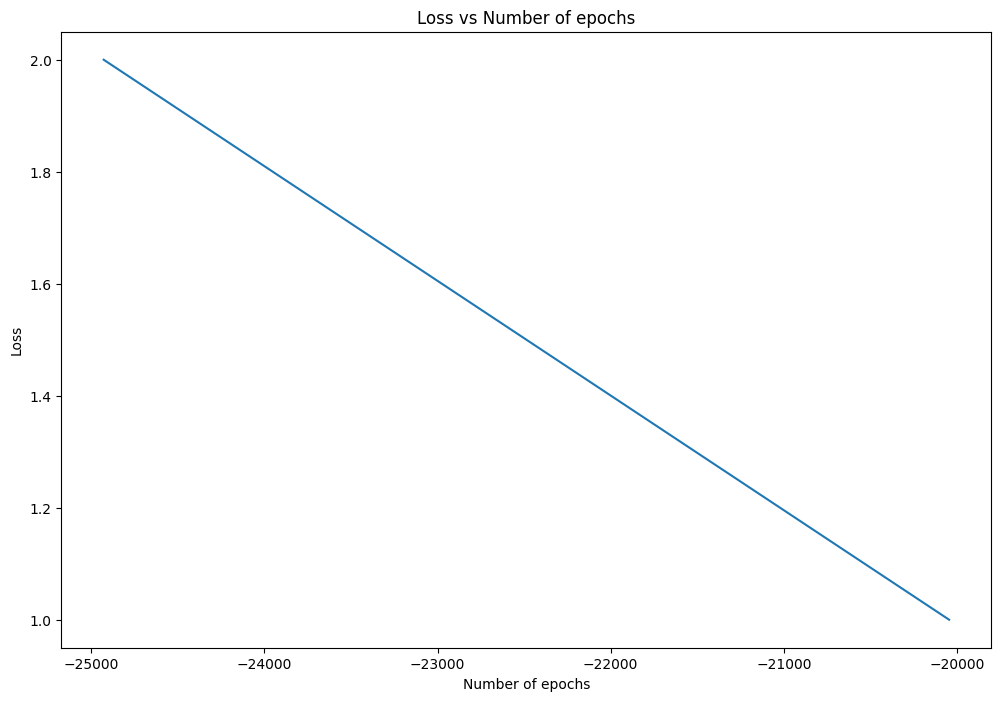

In [18]:
# all_test_preds = []


test_preds = train_model(
    model, 
    train_dataset, 
    test_dataset, 
    output_dim=OUTPUT_DIM,
    loss_fn=nn.BCEWithLogitsLoss(reduction='mean')
)

# all_test_preds.append(test_preds)
#     print()
        

In [ ]:
# # model.load_state_dict(torch.load('tut1-model.pt'))

# test_loss, test_acc = evaluate(model, test_iterator, criterion)

# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')